# A tour of the CPA model

In [1]:
# some standard packages to assist this tutorial
from pprint import pprint
import cpa
import pandas as pd

%load_ext autoreload
%autoreload 2

# Training your model

### Init your model

In [5]:
dataset_path = '../../old_projects/test_AdvAE/datasets/GSM_new.h5ad'
cpa_api = cpa.api.API(
    dataset_path, 
    perturbation_key='condition',
    split_key='split',
    covariate_keys=['cell_type'],
    only_parameters=False,
    hparams={},
    device='cuda',    
)

You can print parameters of the model:

In [6]:
cpa_api.model

CPA(
  (encoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=4999, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=512, out_features=512, bias=True)
      (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (decoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, t

### Start training

In [ ]:
cpa_api.train(max_epochs=100, filename=None, max_minutes=2*60)

Results will be saved to the folder: /tmp/


  0%|                                                   | 0/100 [00:00<?, ?it/s]

### Visualize training history

Computation time: 2 min


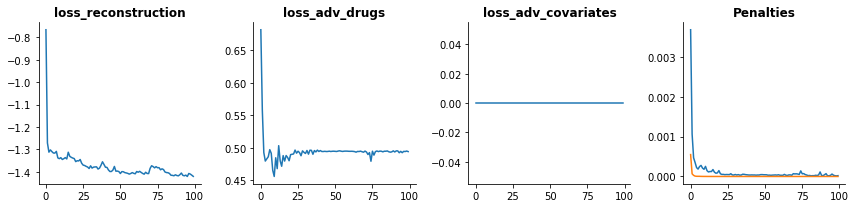

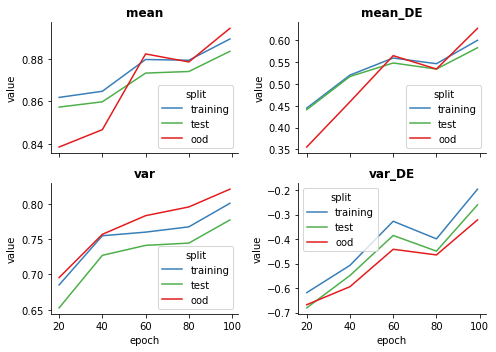

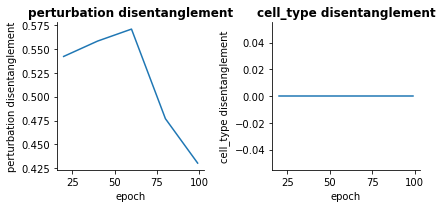

In [5]:
from cpa.plotting import CPAHistory
pretty_history = CPAHistory(cpa_api)
pretty_history.print_time()
pretty_history.plot_losses()
pretty_history.plot_r2_metrics(epoch_min=0)
pretty_history.plot_disentanglement_metrics(epoch_min=0)

In [103]:
perts_anndata = cpa_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 5 × 256
    obs: 'condition'

In [104]:
perts_anndata.X

array([[ 0.20750362,  0.03375564, -0.365881  , ...,  0.00415645,
         0.18235494,  0.05920864],
       [-0.00719398, -0.14307036,  0.04959141, ...,  0.09705448,
         0.38762605, -0.09439207],
       [-0.08116883, -0.12426055,  0.261653  , ...,  0.23996812,
        -0.01149575, -0.08257351],
       [-0.0724621 ,  0.22306025,  0.03836396, ...,  0.20669775,
         0.32210982,  0.07540685],
       [ 0.07065871,  0.24518529, -0.18451819, ..., -0.1893417 ,
        -0.30439222,  0.445815  ]], dtype=float32)

Print and plot covars embeddings.

In [106]:
covars_anndata = cpa_api.get_covars_embeddings('cell_type')
covars_anndata

AnnData object with n_obs × n_vars = 1 × 256
    obs: 'cell_type'

In [107]:
cpa_api.compute_comb_emb(thrh=0)
cpa_api.compute_uncertainty(
                    cov={'cell_type': 'A549'}, 
                    pert='Nutlin', 
                    dose='1.0'
                )

(5.9604645e-08, 0.0, 'A549_Nutlin_1.0', 'A549_Nutlin_1.0')

Setting up a variable for automatic plotting. The plots also could be used separately.

In [108]:
cpa_plots = cpa.plotting.CPAVisuals(cpa_api, fileprefix=None)

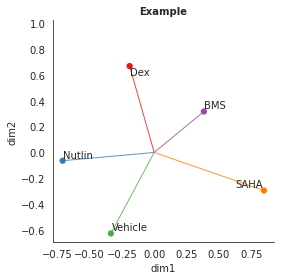

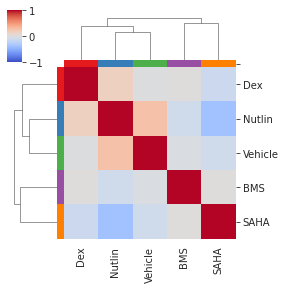

In [109]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=True)

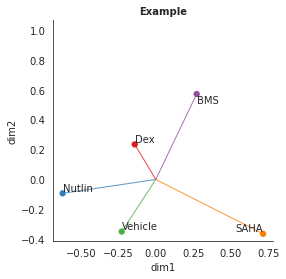

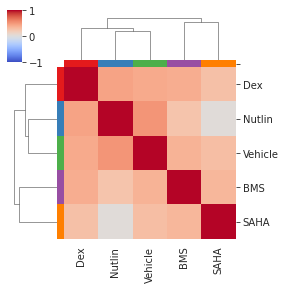

In [110]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts + covars_anndata.X, kind='perturbations', show_text=True)

If your have a lot of cell types or a lot of perturbations, you can also chose to not display their names.

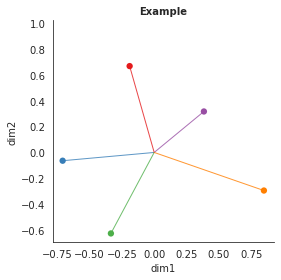

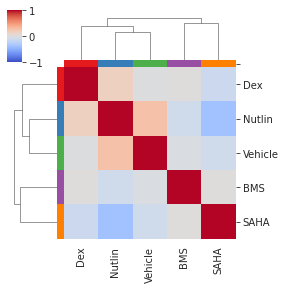

In [111]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=False)

Or I can change the color scheme for the emebddings.

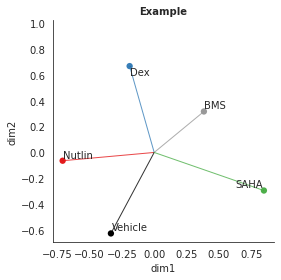

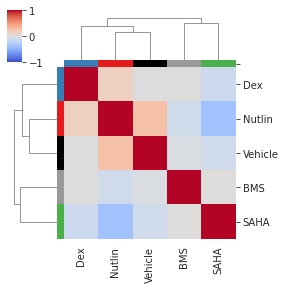

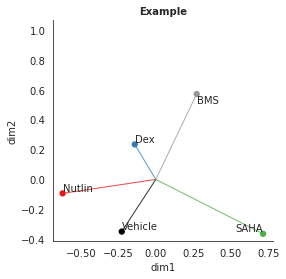

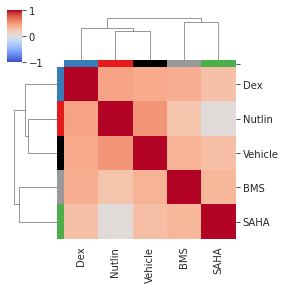

In [112]:
perts_palette = {'BMS': '#999999',                 
                 'SAHA': '#4daf4a',
                 'Dex': '#377eb8',
                 'Nutlin': '#e41a1c',
                 'Vehicle': '#000000'
    
                }

cpa_plots.perts_palette = perts_palette
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=True)
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts + covars_anndata.X, kind='perturbations', show_text=True)

In [113]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_covars, kind='covars')

Embedding contains only 1 vectors. Not enough to plot.


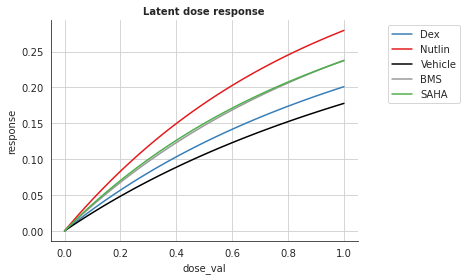

In [117]:
latent_response = cpa_api.latent_dose_response(perturbations=None)
cpa_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=cpa_api.perturbation_key,
    title_name='Latent dose response')

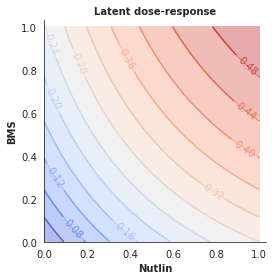

In [118]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_api.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')


CPU times: user 2.62 s, sys: 231 ms, total: 2.85 s
Wall time: 1.21 s


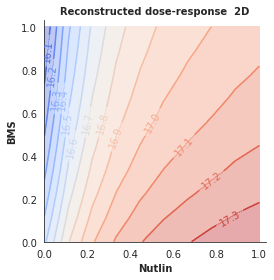

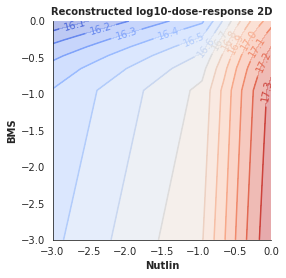

In [119]:
%%time

reconstructed_response2D = cpa_api.get_response2D(
    perturbations=perturbations_pair,
    covar={'cell_type': ['A549']}
)


cpa_plots.plot_contvar_response2D(
    reconstructed_response2D,
    title_name='Reconstructed dose-response  2D',
    logdose=False,
    # xlims=(-3, 0), ylims=(-3, 0)
    )

cpa_plots.plot_contvar_response2D(
    reconstructed_response2D,
    title_name='Reconstructed log10-dose-response 2D',
    logdose=True,
    xlims=(-3, 0), ylims=(-3, 0)
    )

If you want to plot in on a log scale, you can just log values in the data frame.

In [120]:
# %%time
df_reference = cpa_api.get_response_reference()        

In [121]:
# %%time
reconstructed_response = cpa_api.get_response(n_points=100)

You can plot an average response (saved under "response" column) among all genes, however, we don't consider it to be a good metric and strongly advise to look at the individual response among DE genes.

Solid lines in this plot correspond to the model predictions, dashed lines -- linear interpolations between measured points. Dots represent measured points, their color is proportional to the number of cells in this condition. Black dots represent points used in training and red dots correspond to the out-of-distribution examples.

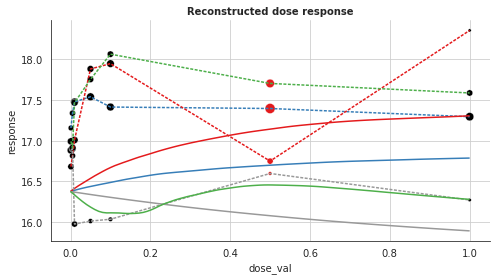

In [122]:
df_reference = df_reference.replace('training_treated', 'train')
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    title_name='Reconstructed dose response')

For example we can take of the top 50 DE genes for Nutlin - MDM2. MDM2 is itself transcriptionally-regulated by p53. And p53 is the target of Nutlin. Therefore, we expect our model to learn it.

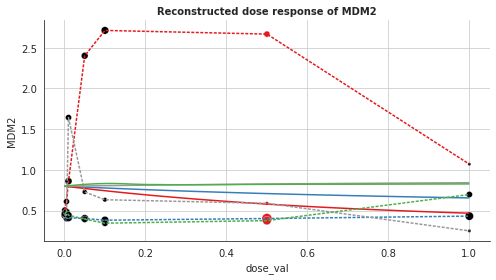

In [123]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

We can also look at this plot on the log10-scale. It makes sense for this dataset, because the measured doses were not evenly distributed.

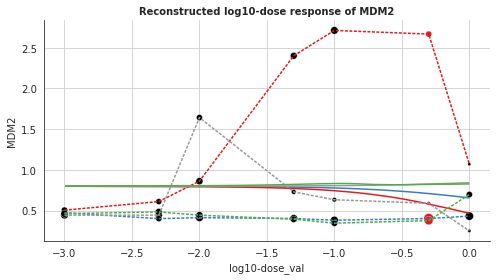

In [124]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    logdose=True,
    title_name='Reconstructed log10-dose response of MDM2')

# Predictions

In [125]:
print('Perturbations:', cpa_api.unique_perts)
print('Covariates:', cpa_api.unique_covars)
print('Datasets splits:', cpa_api.datasets.keys())

Perturbations: ['Dex', 'Nutlin', 'Vehicle', 'BMS', 'SAHA']
Covariates: {'cell_type': ['A549']}
Datasets splits: dict_keys(['training', 'training_control', 'training_treated', 'test', 'test_control', 'test_treated', 'ood', 'loader_tr'])


We can chose control cells from which we want to make our predictions. It is easy to chose these cells from either training or test splits.

In [126]:
genes_control = cpa_api.datasets['test_control'].genes

By default, the prediction function returns means and variances of the applied perturbations. By default, the prediction function returns means and variances of the applied perturbations. 

In [127]:
%%time
anndata_predicted = cpa_api.predict(
    genes_control,
    cov={'cell_type': ['A549', 'A549']}, 
    pert=['BMS', 'Dex'], 
    dose=['1.0', '1.0'],
    return_anndata=True,
    sample=False
)

CPU times: user 113 ms, sys: 45.8 ms, total: 159 ms
Wall time: 80.5 ms


However, in some cases you want to sample from this distribution, so you can explicitly specify it in the predict function.

In [128]:
%%time
anndata_predicted_samples = cpa_api.predict(
    genes_control,
    cov={'cell_type': ['A549', 'A549']}, 
    pert=['BMS', 'Dex'], 
    dose=['1.0', '1.0'],
    return_anndata=True,
    sample=False,
    n_samples=10
)

CPU times: user 147 ms, sys: 29 ms, total: 176 ms
Wall time: 69.3 ms


# Evaluation

In [129]:
genes_control = cpa_api.datasets['training_control'].genes
df_train = cpa_api.evaluate_r2(cpa_api.datasets['training_treated'], genes_control)
df_train['benchmark'] = 'CPA'

In [130]:
genes_control = cpa_api.datasets['test_control'].genes
df_ood = cpa_api.evaluate_r2(cpa_api.datasets['ood'], genes_control)
df_ood['benchmark'] = 'CPA'

In [131]:
genes_control = cpa_api.datasets['test_control'].genes
df_test = cpa_api.evaluate_r2(cpa_api.datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [132]:
df_test = cpa_api.evaluate_r2(cpa_api.datasets['test_treated'], genes_control)
df_test['benchmark'] = 'CPA'

In [133]:
df_ood['split'] = 'ood'
df_test['split'] ='test'
df_train['split'] ='train'

In [134]:
df_score = pd.concat([df_train, df_test, df_ood])
df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells,benchmark,split
18,A549,SAHA,0.001,0.96,0.95,0.86,0.34,169,CPA,test
18,A549,SAHA,0.001,0.95,0.94,0.85,0.33,392,CPA,train
19,A549,SAHA,0.005,0.90,0.75,0.80,0.01,376,CPA,train
19,A549,SAHA,0.005,0.88,0.71,0.77,0.11,143,CPA,test
3,A549,SAHA,0.5,0.88,0.45,0.80,-0.14,604,CPA,ood
23,A549,SAHA,1.0,0.85,0.32,0.72,0.16,282,CPA,train
23,A549,SAHA,1.0,0.84,0.31,0.71,0.21,137,CPA,test
20,A549,SAHA,0.01,0.83,0.51,0.63,-0.21,383,CPA,train
20,A549,SAHA,0.01,0.81,0.48,0.63,-0.18,160,CPA,test
22,A549,SAHA,0.1,0.81,0.17,0.69,0.08,297,CPA,train


In [135]:
cols_print = ['condition', 'dose_val','R2_mean', 'R2_mean_DE', 'R2_var', 'R2_var_DE', 'split', 'num_cells']
df_score = df_score.round(2).sort_values(by=['condition', 'R2_mean', 'R2_mean_DE'], ascending=False)
print(df_score[cols_print])
# print(df_score[cols_print].to_latex(index=False))

   condition dose_val  R2_mean  R2_mean_DE  R2_var  R2_var_DE  split num_cells
18      SAHA    0.001     0.96        0.95    0.86       0.34   test       169
18      SAHA    0.001     0.95        0.94    0.85       0.33  train       392
19      SAHA    0.005     0.90        0.75    0.80       0.01  train       376
19      SAHA    0.005     0.88        0.71    0.77       0.11   test       143
3       SAHA      0.5     0.88        0.45    0.80      -0.14    ood       604
23      SAHA      1.0     0.85        0.32    0.72       0.16  train       282
23      SAHA      1.0     0.84        0.31    0.71       0.21   test       137
20      SAHA     0.01     0.83        0.51    0.63      -0.21  train       383
20      SAHA     0.01     0.81        0.48    0.63      -0.18   test       160
22      SAHA      0.1     0.81        0.17    0.69       0.08  train       297
21      SAHA     0.05     0.77        0.11    0.63      -0.11  train       299
22      SAHA      0.1     0.76       -0.02    0.58  

# Uncertainty

We can profile all the predictions with an uncertainty score. Low uncertainty means "good/trustworthy" predictions, high values mean "bad/unknown quality" predictions.

In [136]:
cpa_api.measured_points['all']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 0.5],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 0.5],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 0.5],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 0.5],
  'Vehicle': [1.0]}}

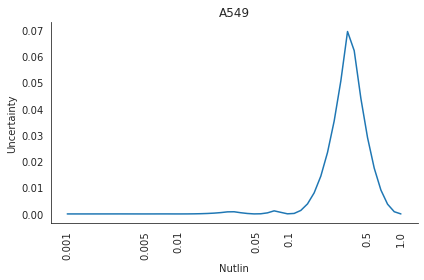

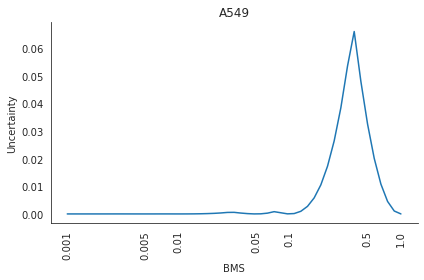

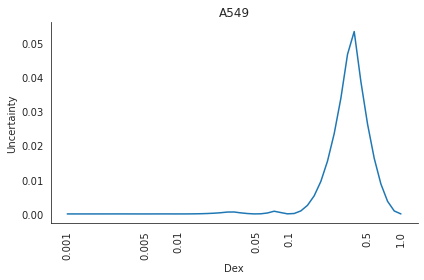

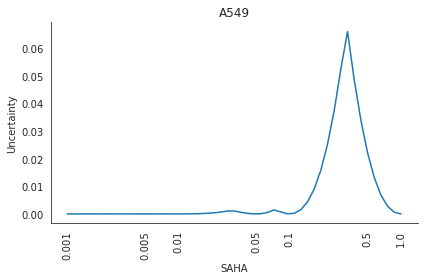

In [137]:
import cpa.plotting as pl

for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = pl.plot_uncertainty_dose(
        cpa_api,
        cov={'cell_type': 'A549'},
        pert=drug,
        N=51,
        measured_points=cpa_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine'
    )

Previously, we demonstrated CPA predictions for drugs combinations. But our training data didn't contain any combinations examples. How much can we trust these examples? We can try to asses by running model uncertainty predictions:

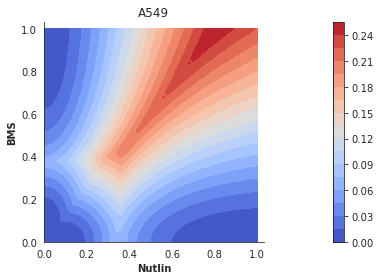

In [138]:
df_pred2D = pl.plot_uncertainty_comb_dose(
    cpa_api=cpa_api,
    cov={'cell_type': 'A549'},
    pert='Nutlin+BMS',
    N=51,
    cond_key='treatment',
    metric='cosine',
)

And here is the predicted response we plotted before:

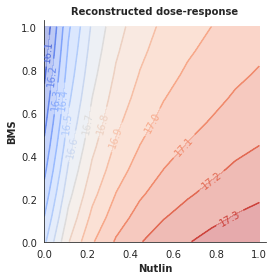

In [139]:
cpa_plots.plot_contvar_response2D(
    reconstructed_response2D, 
    title_name='Reconstructed dose-response',
    logdose=False)

And now keep in mind, that the highest uncertainty for OOD cases (for which we know that their predictions were fairly good) is 0.002:

In [140]:
df_pred['uncertainty_cosine'].max().round(3)

0.066

Therefore, be careful with interpreting drug combinations in this dataset!

In [141]:
cpa_api.measured_points['training']['A549']['Nutlin']

[0.001, 0.005, 0.01, 0.05, 0.1, 1.0]